## <u>Bayesian GAM of Southern Ocean Chlorophyll Time Series</u>:
### <u>Part I - Single Zone Time Series</u>
by Erdem M. Karaköylü



### <u>Summary</u>
This notebook documents the development of Bayesian Generalized Additive Models (GAM) aimed at diagnosing and predicting marine chlorophyll time series. The GAMs featured here include one or more of three components; a global linear trend, a seasonal cycle based on a fourier series of varying order, and a autoregressive residual signal of lag 1 (AR1). The region of interest is the Southern Ocean (SO), decomposed into several zones. For development purposes, I focus here on the Atlantic Ocean Sub-Tropical Zone (AOSTZ). The study follows a recent [published paper](https://doi.org/10.1029/2019GL083163) on chlorophyll in the SO, which is based on a shorter time series.

The progression of the notebook follows an the development of models of increasing complexity. The models are then fit, and their predicted performance on out-of-sample data are evaluated using criteria from Information Theory. These criteria include the Widely Available Information Criterion (WAIC) and the Pareto-Smoothed Importance Sampling Leave-One-Out Cross Validation (PSIS-LOOCV). These constructs are well suited for dealing with Bayesian models as they take the resulting posterior distribution of each model to estimate its predictive skill on out-of-sample data.  I compare these criteria to select the better performing model(s.)

The models developed below are coded using the Python probabilistic programming library [PyMC3](https://doi.org/10.7717/peerj-cs.55).

In [1]:
# Import necessary library
import pathlib
import pickle
from collections import namedtuple
from platform import python_version as pv
from functools import partial

import pandas as pd
import numpy as np
from numpy import pi as π
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler

import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as pl
import matplotlib.dates as mdates
from matplotlib import rcParams
import arviz as ar

In [2]:
def print_ver(pkg):
    print(f'{pkg.__name__} version: {pkg.__version__}')
    
print(f'python version: {pv()}')
for p in [pd, np, pm, ar]:
    print_ver(p)

python version: 3.7.3
pandas version: 0.24.2
numpy version: 1.16.4
pymc3 version: 3.7
arviz version: 0.4.1


In [3]:
# Graphical settings
%matplotlib inline

years = mdates.YearLocator(day=1)
months = mdates.MonthLocator(bymonthday=1)
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18
rcParams['axes.formatter.limits'] = (-3, 2)

The data is stored in a serialized (pickled) tabular [pandas](https://pandas.pydata.org/) dataframe and is loaded below

In [4]:
df = pd.read_pickle('../../pickleJar/df.pkl')

In [5]:
#quick formatting to remove empty spaces in column names
df.rename(columns={col: col.strip() for col in df.columns}, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 1997-09-01 to 2018-04-01
Data columns (total 14 columns):
sam        248 non-null float64
aao        248 non-null float64
iostz      248 non-null float64
iosostz    248 non-null float64
postz      248 non-null float64
posostz    248 non-null float64
aostz      248 non-null float64
aosostz    248 non-null float64
iopooz     241 non-null float64
popooz     188 non-null float64
aopooz     248 non-null float64
iosaaz     248 non-null float64
posaaz     248 non-null float64
aosaaz     248 non-null float64
dtypes: float64(14)
memory usage: 29.1 KB


The dataframe above contains time series 14 zones by which SO was divided. Their statistical properties are displayed below:

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sam,248.0,0.519879,1.701669,-5.770000,-0.642500,0.580000,1.652500,4.920000
aao,248.0,0.175113,0.973178,-2.798000,-0.448250,0.197000,0.884500,2.573000
iostz,248.0,0.213579,0.027127,0.142600,0.194450,0.217491,0.233288,0.287270
iosostz,248.0,0.216339,0.058586,0.147280,0.174935,0.201763,0.239613,0.641870
postz,248.0,0.201598,0.048607,0.110340,0.164000,0.197431,0.231166,0.335140
posostz,248.0,0.237798,0.107210,0.119390,0.163355,0.186825,0.289744,0.639570
aostz,248.0,0.292012,0.043535,0.199870,0.261736,0.281545,0.315765,0.415390
aosostz,248.0,0.363231,0.125154,0.182640,0.266058,0.342921,0.444249,0.969560
iopooz,241.0,0.197709,0.070319,0.128662,0.164502,0.180248,0.221227,1.067500
popooz,188.0,0.193421,0.057796,0.112061,0.150147,0.171223,0.226092,0.384627


I chose to use the AOSTZ timeseries as it is relatively clean with a full complement of observations. The data is displayed below. 

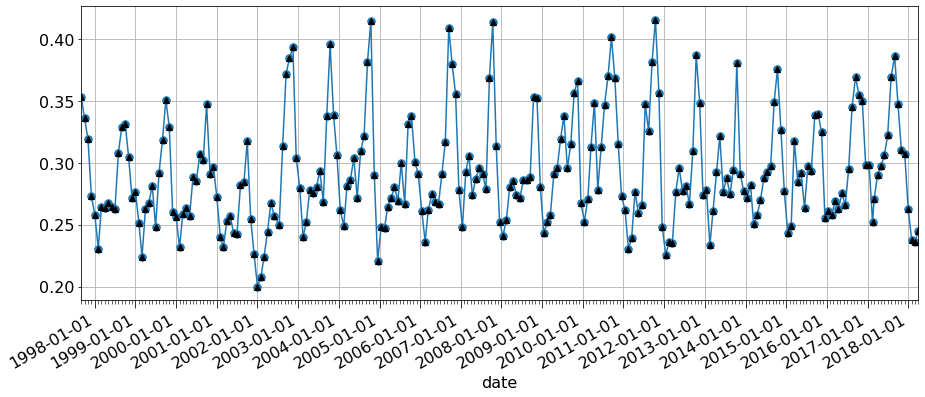

In [8]:
_, ax = pl.subplots(figsize=(15, 6))
df.aostz.plot(marker='.', ax=ax, markersize=15)
df.aostz.interpolate().plot(ls='', marker='^', color='k', ax=ax);
ax.xaxis_date()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.grid()

#### <u>Extracting and Standardizing the Data</u>

Model fitting is often best served by standardizing the data; namely, subtracting the mean and dividing by the standard deviation:

In [9]:
d_aostz = df['aostz'].resample('MS').mean().interpolate()
x = np.arange(d_aostz.size)
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
y_s = std_scaler.fit_transform(d_aostz.values[:,None]).flatten()
t_s = minmax_scaler.fit_transform(x[:,None]).flatten()

y = d_aostz.values

Save the training data:

In [10]:
datadict = dict(frame=d_aostz, x=x, y_s=y_s, scaler=std_scaler)
with open('../../pickleJar/datadict.pkl', 'wb') as fb:
    pickle.dump(datadict, fb, protocol=pickle.HIGHEST_PROTOCOL)

<a id=helpers />

### <u>Model types and helper functions</u>
In order to avoid rewriting model definition code, I wrote a few functions to automate model creation. Three types of models, which are experimented with are wrapped in Python functions below:
1. Global linear trend only. This is essentially a linear regression model.
2. Global linear trend and fourier series-based seasonal cycle. Note that the number of fourier components can be specified during model instantiation.
3. Global trend, seasonal cyle and lag-1 autoregressive model.

In addition a fourier series helper function is also available to reduce code when fitting the seasonal cycle.

In [72]:
def mdl_trend_only(m, t):
    """
    m [pymc3 Model class]: model object
    """
    with m:
        σ = pm.Exponential('σ', 1)
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        μ = itc + slp * x
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

        
def fourier_series(t, p=12, n=1):
    """
    input:
    ------
    t [numpy array]: vector of time index
    p [int]: period
    n [int]: number of fourier components
    
    output:
    -------
    sinusoids [numpy array]: 2D array of cosines and sines
    """
    p = p / t.size
    wls = 2 * π * np.arange(1, n+1) / p
    x_ = wls * t[:, None]
    sinusoids = np.concatenate((np.cos(x_), np.sin(x_)), axis=1)
    return sinusoids


def mdl_season_only(m, n_fourier, t):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    t [numpy array]: vector of time index
    """
    with m:
        σ = pm.Exponential('σ', 1)
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(t, n=n_fourier), f_coefs)
        #tau = pm.Gamma('tau', 10, 2) 
        #y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)
        y_lik = pm.Normal('y_lik', mu=season, sd=σ, observed=y_s)

        
def mdl_trend_season(m, n_fourier, t):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    t [numpy array]: vector of time index
    """
    with m:
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(t, n=n_fourier), f_coefs)
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * t)

        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('μ', trend + season)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

        
def mdl_trend_season_ar1(m, n_fourier, t):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    """
    with m:
        
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = pm.Deterministic('season', 
                                  tt.dot(fourier_series(t, n=n_fourier), f_coefs)
                                 )
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * t)
        
        # residual estimation
        k_ = pm.Uniform('k', -1.1, 1.1)
        tau_ = pm.Gamma('tau', 10, 3)
        ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_s.size)
        
        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('μ', trend + season + ar1)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)



In [72]:
def fourier_series(t, p=12, n=1):
    """
    input:
    ------
    t [numpy array]: vector of time index
    p [int]: period
    n [int]: number of fourier components
    
    output:
    -------
    sinusoids [numpy array]: 2D array of cosines and sines
    """
    p = p / t.size
    wls = 2 * π * np.arange(1, n+1) / p
    x_ = wls * t[:, None]
    sinusoids = np.concatenate((np.cos(x_), np.sin(x_)), axis=1)
    return sinusoids


def trend_mdl(mdl, t):
    """
    m [pymc3 Model class]: model object
    t [numpy array]: vector of time index
    """
    with mdl:
        σ = pm.Exponential('σ', 1)
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = itc + slp * t
        #y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)
        return trend


def season_mdl(mdl, n_fourier, t):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    t [numpy array]: vector of time index
    """
    with mdl:
        σ = pm.Exponential('σ', 1)
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(t, n=n_fourier), f_coefs)
    return season

        
def resid_mdl(mdl, data_length):
    # residual estimation
    with mdl:
        k_ = pm.Uniform('k', -1.1, 1.1)
        tau_ = pm.Gamma('tau', 10, 3)
        ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_s.size)
    return ar1


def mdl_trend(obs_, t):
    m = pm.Model()
    μ = pm.Deterministic('μ', 0)
    σ = pm.HalfCauchy('σ')
    trend = trend_mdl(m, t)
    μ += trend
    
    

def mdl_trend_season(m, n_fourier, t):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    t [numpy array]: vector of time index
    """
    with m:
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(t, n=n_fourier), f_coefs)
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * t)

        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('μ', trend + season)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

        
def mdl_trend_season_ar1(m, n_fourier, t):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    """
    with m:
        
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = pm.Deterministic('season', 
                                  tt.dot(fourier_series(t, n=n_fourier), f_coefs)
                                 )
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * t)
        
        # residual estimation
        k_ = pm.Uniform('k', -1.1, 1.1)
        tau_ = pm.Gamma('tau', 10, 3)
        ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_s.size)
        
        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('μ', trend + season + ar1)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)



<a id=TrendOnly />

### <u>Model Implementations</u>
#### 1. <u>Linear Trend Model</u>

In [73]:
m1 = pm.Model()
m1.name='linear_trend'
mdl_trend_only(m1, t_s)
with m1:
    trace_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [linear_trend_intercept, linear_trend_slope, linear_trend_σ]
Sampling 4 chains: 100%|██████████| 28000/28000 [00:10<00:00, 2766.04draws/s]


In [ ]:
render = pm.model_to_graphviz(m1)
render.format = 'png'
render.render('model1_linear_trend',
              directory='../../figjar/model1_linear_trend.png')

A [Kruschke](https://www.elsevier.com/books/doing-bayesian-data-analysis/kruschke/978-0-12-405888-0) diagram summarizes the linear trend model structure below:

<img src='../../figjar/model1_linear_trend.png' />

<a id=SeaonalOnly />

#### 2. <u>Fourier-based seasonal cycle models</u><br>
Below I try a number of models differing in the number of fourier components used in the approximation. Initially I forego the trend and focus on the seasonal cycle only, attempting to fit models with different number of fourier components (i.e. order of the fourier series used). Note that typically models with weekly periodicty are fit with 3 fourier components, while models with yearly periodicity are fit with 7 fourier components.
<br><br>
\\(\rightarrow\\)3 fourier components (6 coefficients):

In [74]:
m2_f3 = pm.Model()
mdl_season_only(m2_f3, n_fourier=3, t=t_s)

In [ ]:
render2 = pm.model_to_graphviz(m2_f3)
render2.format='png'
render2.render('fourier_only', directory='../../figjar/');

Kruschke diagram of the seasonaly cycle-only model:

<img src='../../figjar/fourier_only.png' />

In [75]:
with m2_f3:
    trace_m2f3 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:09<00:00, 4121.20draws/s]


To get a sense of whether fourier components are important or not, plotting the posterior for each fourier coefficient, overlaying a '0' vertical reference line (below in orange) can be useful. The assessment is whether, and in which case how tightly, the posterior overlaps the reference line.

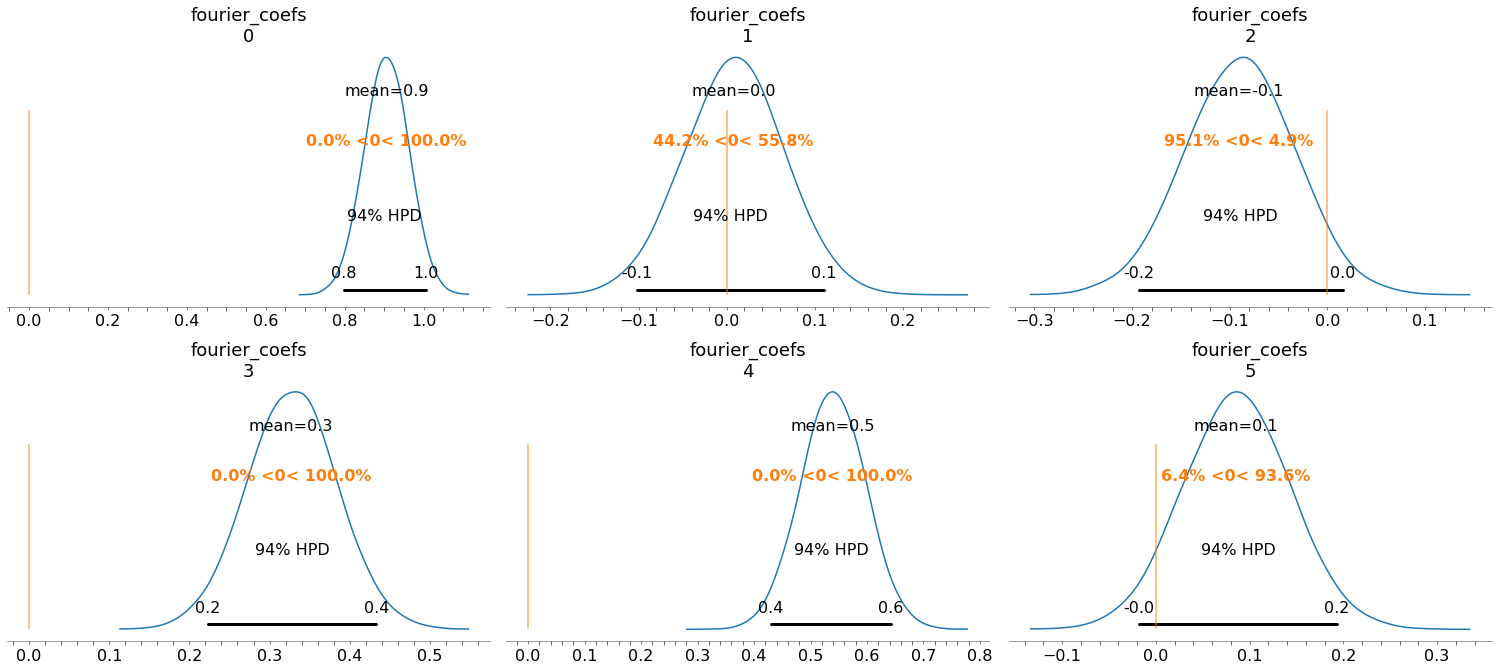

In [20]:
ar.plot_posterior(trace_m2f3, var_names=['fourier_coefs'], ref_val=0);

\\(\rightarrow\\) 5 fourier components (10 coefficients)

In [22]:
m2_f5 = pm.Model()
mdl_season_only(m2_f5, n_fourier=5, t=t_s)

In [23]:
with m2_f5:
    trace_m2f5 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:16<00:00, 2369.11draws/s]


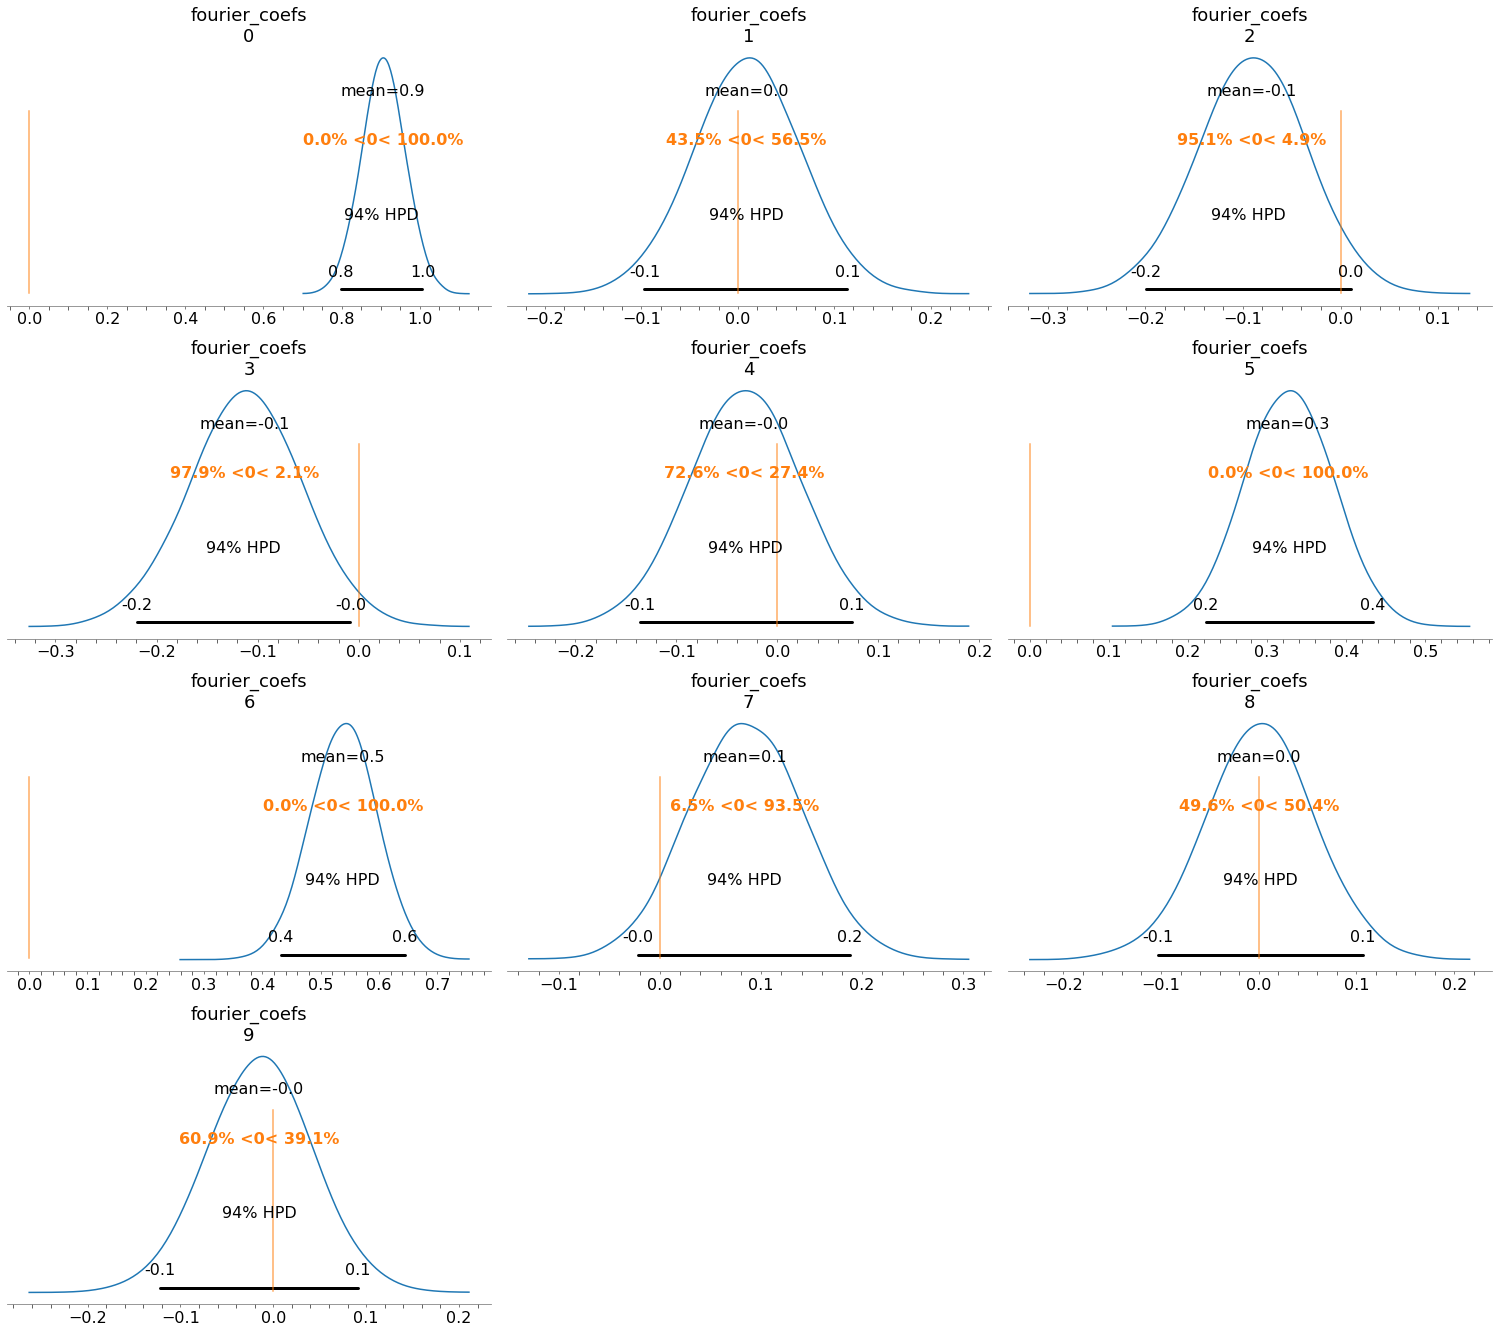

In [24]:
ar.plot_posterior(trace_m2f5, var_names=['fourier_coefs'], ref_val=0);

\\(\rightarrow\\)7 fourier components

In [26]:
m2_f7 = pm.Model()
mdl_season_only(m2_f7, n_fourier=7, t=t_s)

In [27]:
with m2_f7:
    trace_m2f7 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:20<00:00, 1971.13draws/s]


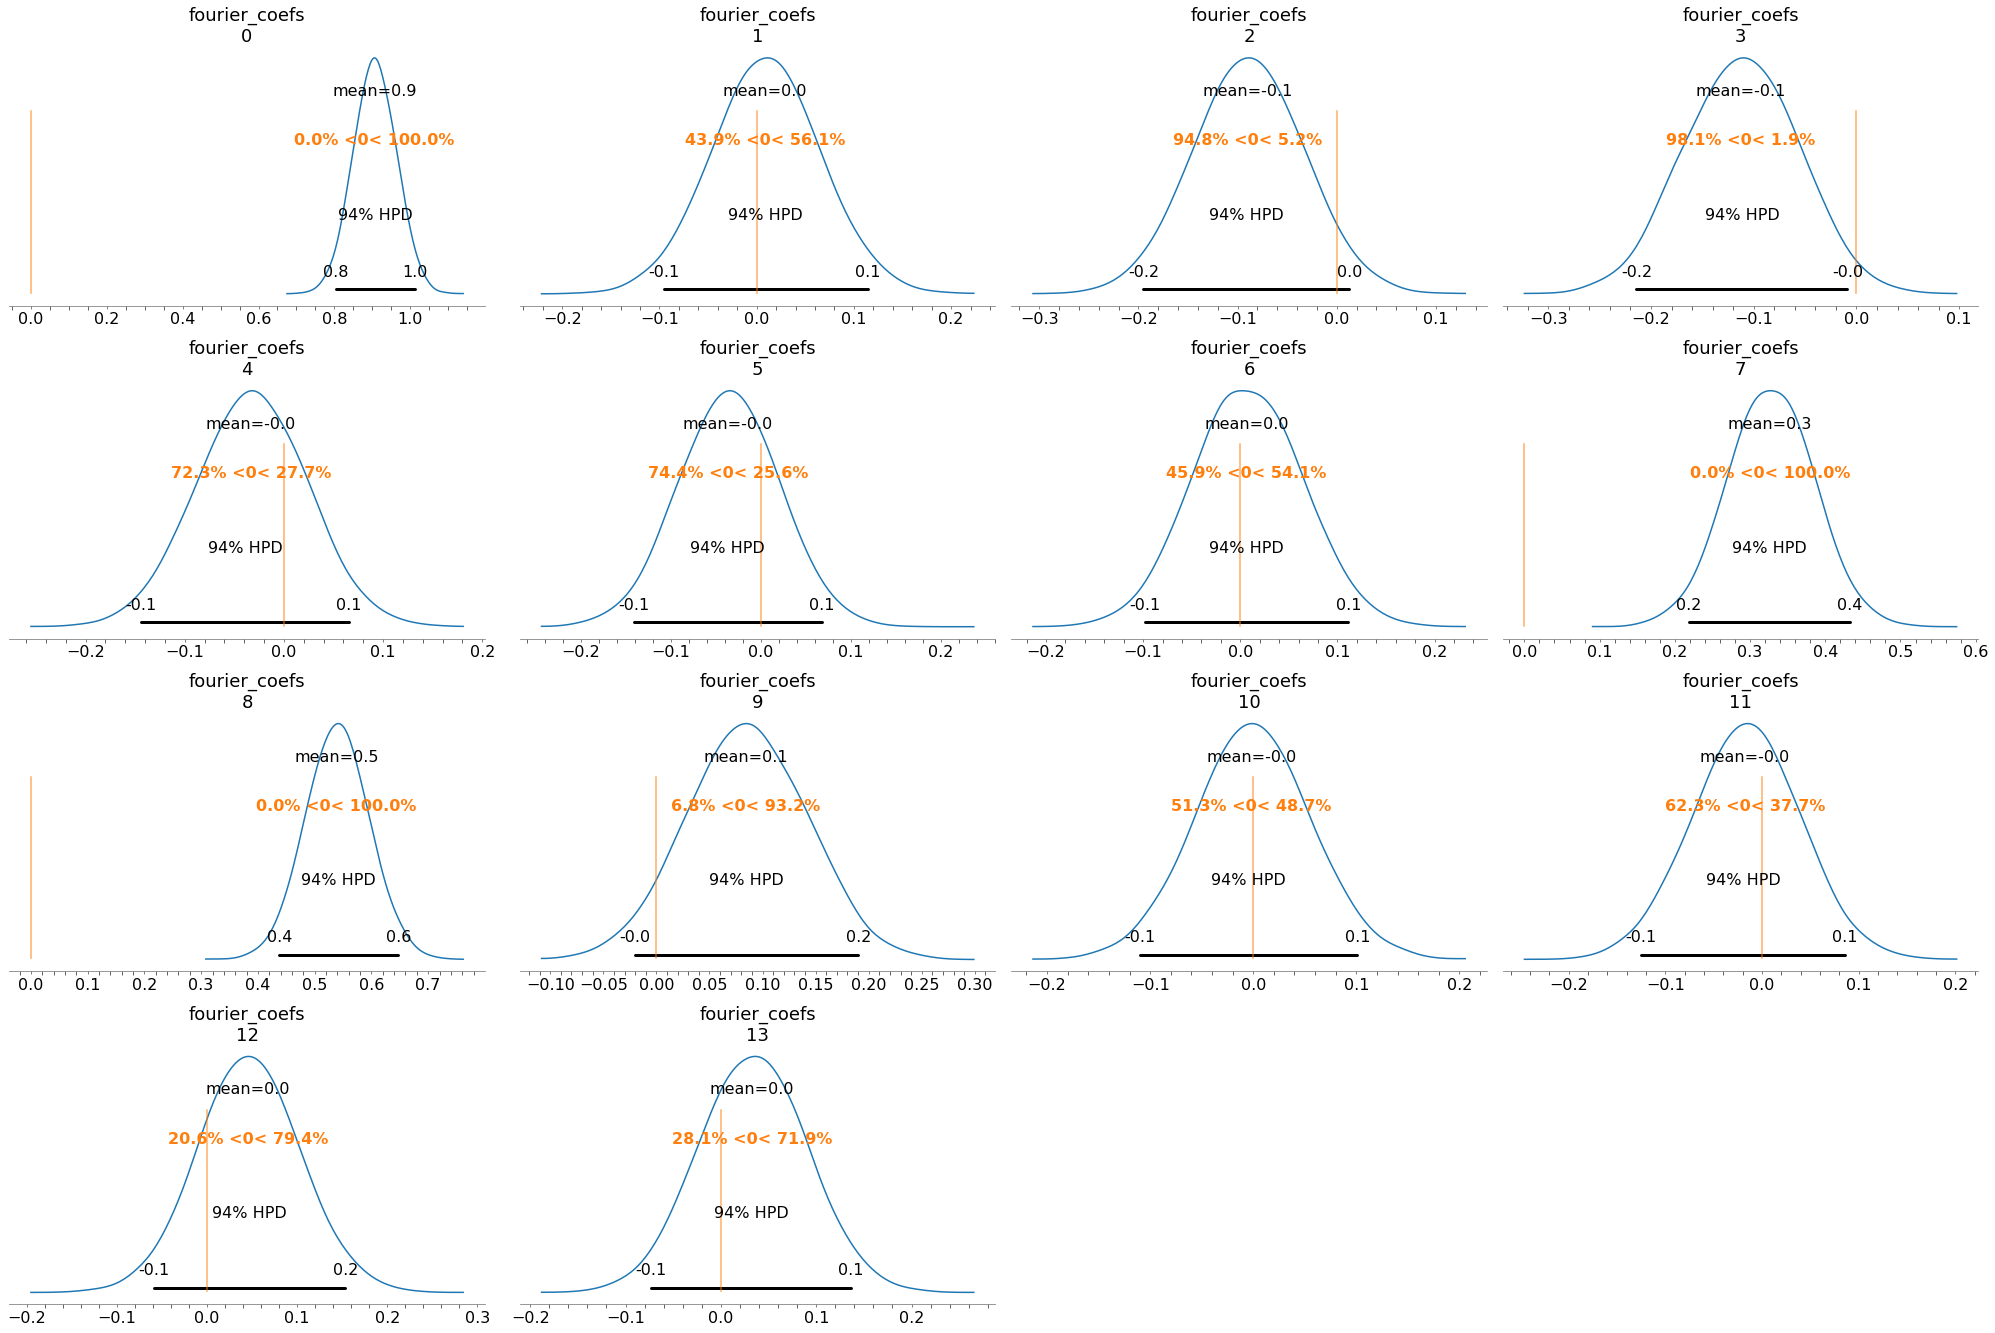

In [28]:
ar.plot_posterior(trace_m2f7, var_names=['fourier_coefs'], ref_val=0);

\\(\rightarrow\\)4 fourier components

In [32]:
m2_f4 = pm.Model()
mdl_season_only(m2_f4, n_fourier=4, t=t_s)

In [33]:
with m2_f4:
    trace_m2f4 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:11<00:00, 3348.20draws/s]


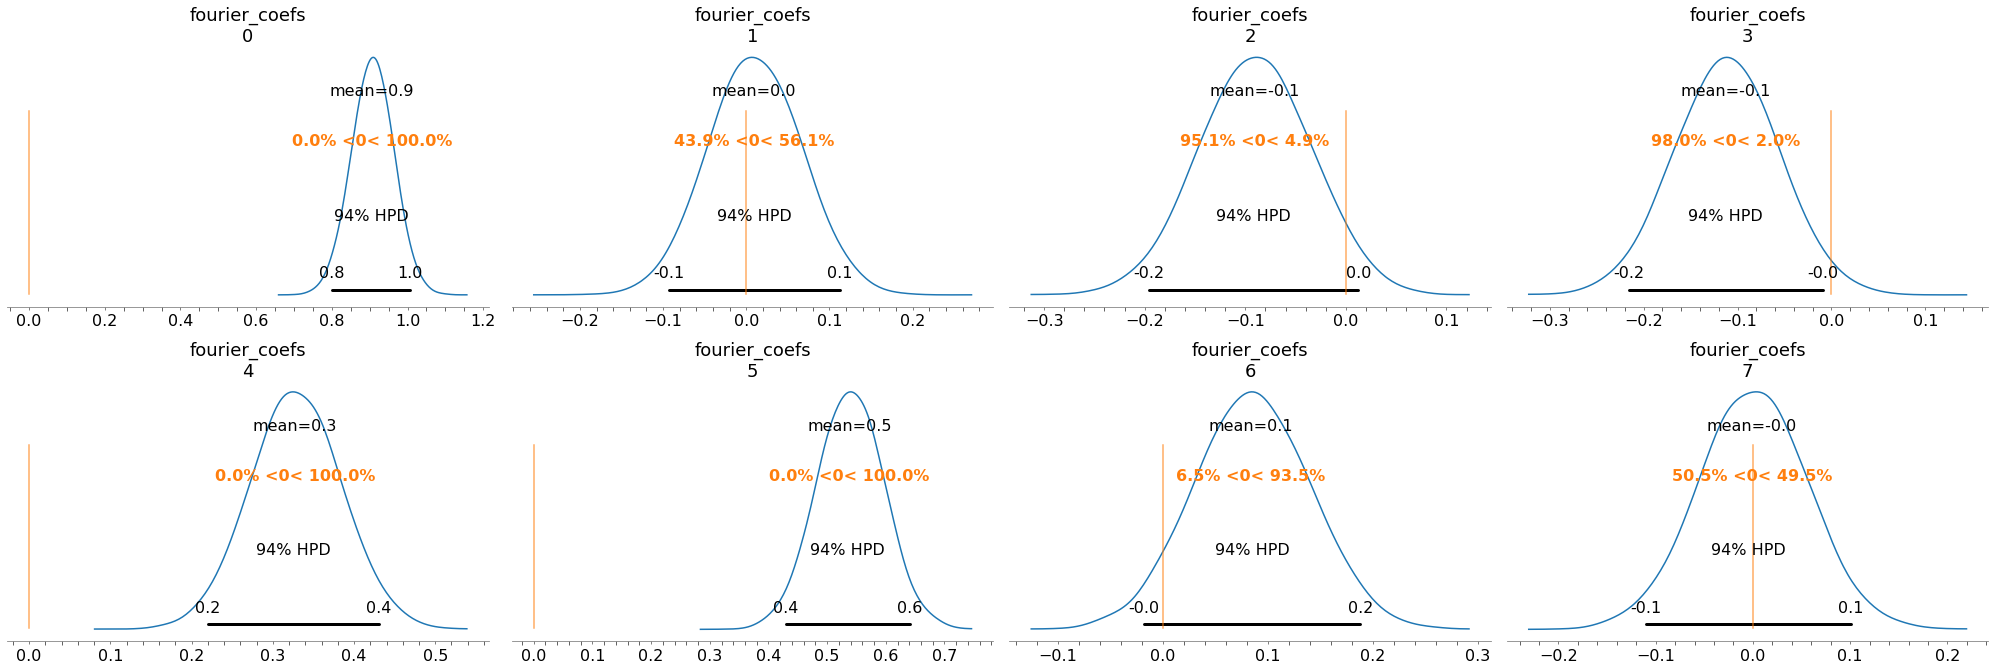

In [34]:
ar.plot_posterior(trace_m2f4, var_names=['fourier_coefs'], ref_val=0);

\\(\rightarrow\\) single fourier component

In [35]:
m2_f1 = pm.Model()
mdl_season_only(m2_f1, n_fourier=1, t=t_s)

In [36]:
with m2_f1:
    trace_m2f1 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:07<00:00, 5538.21draws/s]


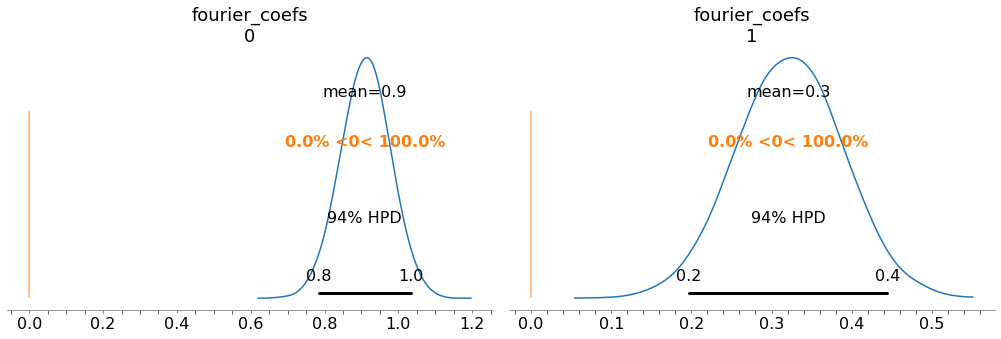

In [37]:
pm.plot_posterior(trace_m2f1, var_names=['fourier_coefs'], ref_val=0);

<u>Comparing predicted performance on out-of-sample data (with WAIC)</u>:

WAIC is a information decision based model performance measurement, akin to AIC  in that both model performance and complexity are used for assessment. However, WAIC  makes use of the posterior distribution and is therefore better suited to Bayesian modeling.

In [38]:
m2_f1.name = 'fourier_N1'
m2_f3.name = 'fourier_N3'
m2_f4.name = 'fourier_N4'
m2_f5.name = 'fourier_N5'
m2_f7.name = 'fourier_N7'

In [39]:
ar.compare({m2_f1.name: trace_m2f1, m2_f3.name: trace_m2f3,
            m2_f4.name: trace_m2f4, m2_f5.name: trace_m2f5,
            m2_f7.name: trace_m2f7,})

/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
fourier_N4,473.036,8.8836,0,0.468351,23.5262,0,True,deviance
fourier_N3,473.532,7.08922,0.495699,0.435883,23.3163,4.04447,True,deviance
fourier_N5,476.845,10.8433,3.80857,0.0886228,23.9403,1.2904,True,deviance
fourier_N7,483.542,14.567,10.5061,0.00702462,22.4714,2.7279,True,deviance
fourier_N1,551.01,3.08201,77.9736,0.000118563,23.4215,17.1341,False,deviance


WAIC has some issues, to double check the result I'll use Pareto-Smoothed Importance Sampling Leave-One-Out Cross Validation (ic='loo' in method keyword below)

In [40]:
ar.compare({m2_f1.name: trace_m2f1, m2_f3.name: trace_m2f3,
            m2_f4.name: trace_m2f4, m2_f5.name: trace_m2f5,
            m2_f7.name: trace_m2f7,}, ic='loo')

,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
fourier_N4,473.06,8.8958,0,0.466897,23.6698,0,False,deviance
fourier_N3,473.55,7.09825,0.489342,0.437704,23.822,4.04556,False,deviance
fourier_N5,476.89,10.8659,3.82932,0.0890773,24.0654,1.29005,False,deviance
fourier_N7,483.665,14.6282,10.6041,0.00632186,23.7252,2.73074,False,deviance
fourier_N1,551.011,3.08285,77.9509,2.46659e-09,23.6583,17.1358,False,deviance


The table above confirms that a 4-component fourier series model approximates well the yearly seasonal cycle in the data, and the 3-component one is not too far behind. I'll retain those two for further evaluation. For good measure I'll compare these two with the linear trend model:

In [41]:
# Just making sure 5-component is significantly behinde (2.6 is z-score for 99% )
3.82932 + np.array([-1, 1]) * 1.29 * 2.6

array([0.47532, 7.18332])

In [43]:
ar.compare({m1.name: trace_1, m2_f3.name: trace_m2f3, m2_f4.name: trace_m2f4},
           ic='loo')

,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
fourier_N4,473.06,8.8958,0,0.538951,23.3611,0,False,deviance
fourier_N3,473.55,7.09825,0.489342,0.461049,24.5918,4.04556,False,deviance
linear_trend,704.975,2.93594,231.914,1.32585e-29,24.4033,26.0082,False,deviance


Based on the above, I'll retain the 3- and 4-component fourier models and store them in a special data structure provided by the [ArviZ](https://arviz-devs.github.io/arviz/) package, in which I will also include prior- and posterior-predictive simulations for later use:

In [ ]:
m2_f3_inference = ar.from_pymc3(trace=trace_m2f3, 
                                prior=pm.sample_prior_predictive(model=m2_f3),
                                posterior_predictive=pm.sample_posterior_predictive(trace_m2f3, model=m2_f3))

In [ ]:
m2_f4_inference = ar.from_pymc3(trace=trace_m2f4, prior=pm.sample_prior_predictive(model=m2_f4),
                               posterior_predictive=pm.sample_posterior_predictive(trace_m2f4, model=m2_f4))

In [ ]:
m2_f3_inference.to_netcdf('../../pickleJar/model_results_nc/m2f3.nc')
m2_f4_inference.to_netcdf('../../pickleJar/model_results_nc/m2f4.nc')

<a id=TrendSeasonality />

### Trend + Seasonality

Given the results from the previous section, I will develop two models: 
* a 3-component fourier series sub-model combined with a global trend submodel.
* a 4-component ...

In [44]:
m3_f4 = pm.Model()
mdl_trend_season(m3_f4, n_fourier=4, t=t_s)

In [ ]:
render_m3_f4 = pm.model_to_graphviz(m3_f4)
render_m3_f4.format='png'
render_m3_f4.render('m3_linear_&_f4', directory='../../figjar/')

<img src='../../figjar/m3_linear_&_f4.png' />

In [45]:
with m3_f4:
    trace_m3f4 = pm.sample(5000, tune=25000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:34<00:00, 3454.87draws/s]


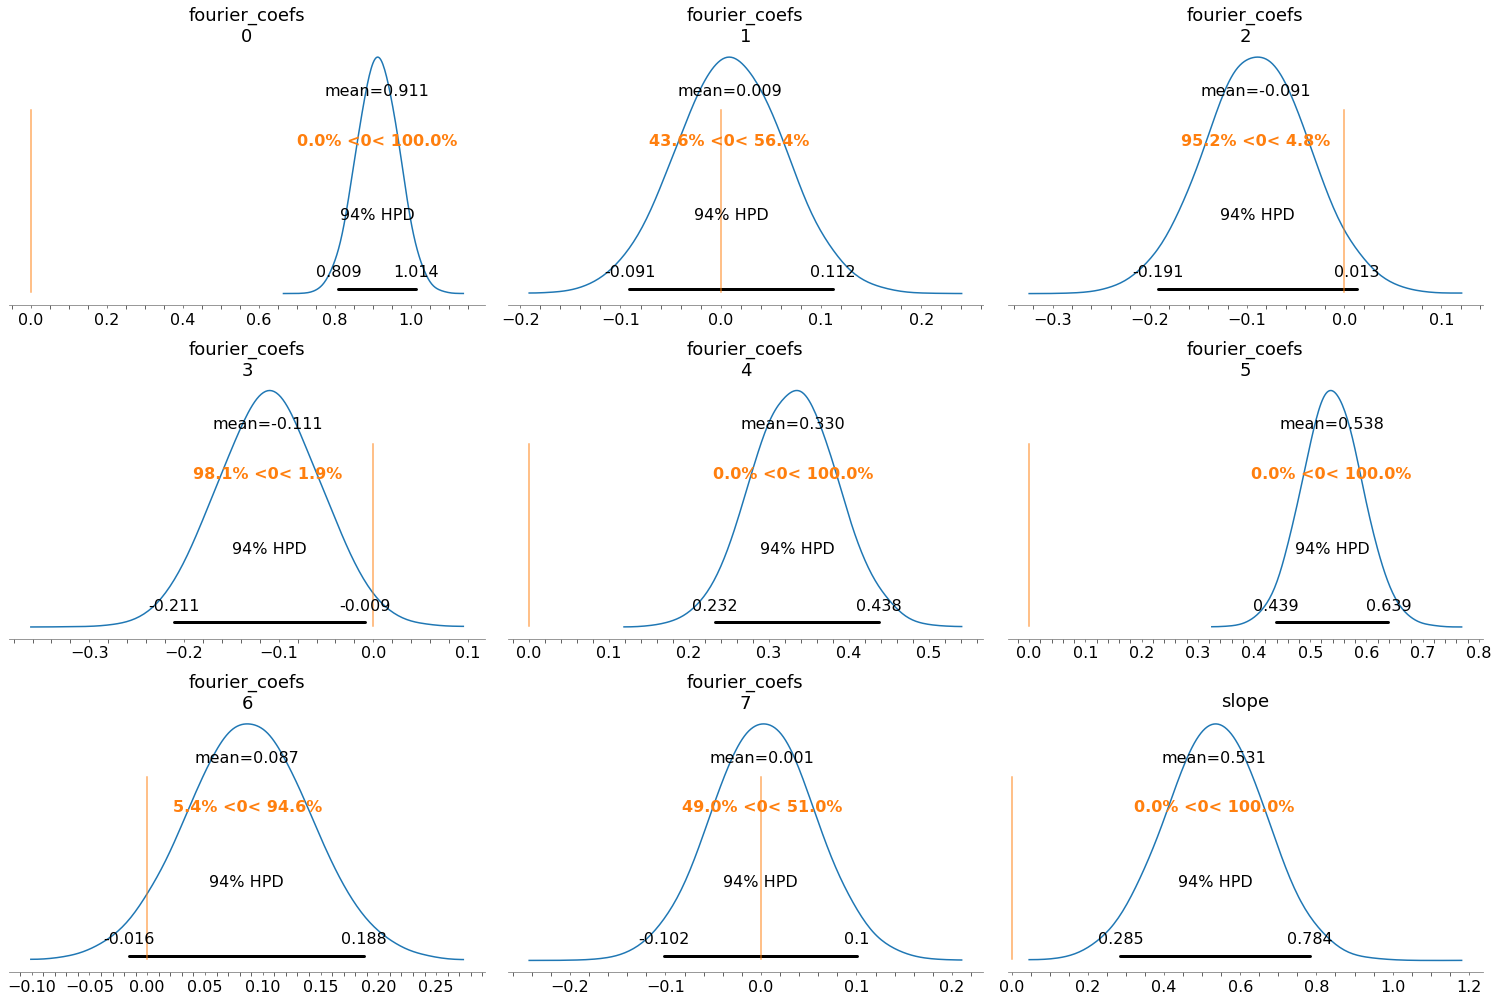

In [46]:
vars_ = ['fourier_coefs', 'slope',]
ar.plot_posterior(trace_m3f4, var_names=vars_, ref_val=0, round_to=3);

In [47]:
m3_f3 = pm.Model()
mdl_trend_season(m3_f3, n_fourier=3, t=t_s)

In [49]:
with m3_f3:
    trace_m3f3 = pm.sample(5000, tune=35000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:45<00:00, 3510.29draws/s]
The acceptance probability does not match the target. It is 0.6803428543487952, but should be close to 0.8. Try to increase the number of tuning steps.


There was one warning during the fit, which is worth keeping in mind but at this point is not an obstacle to going ahead.

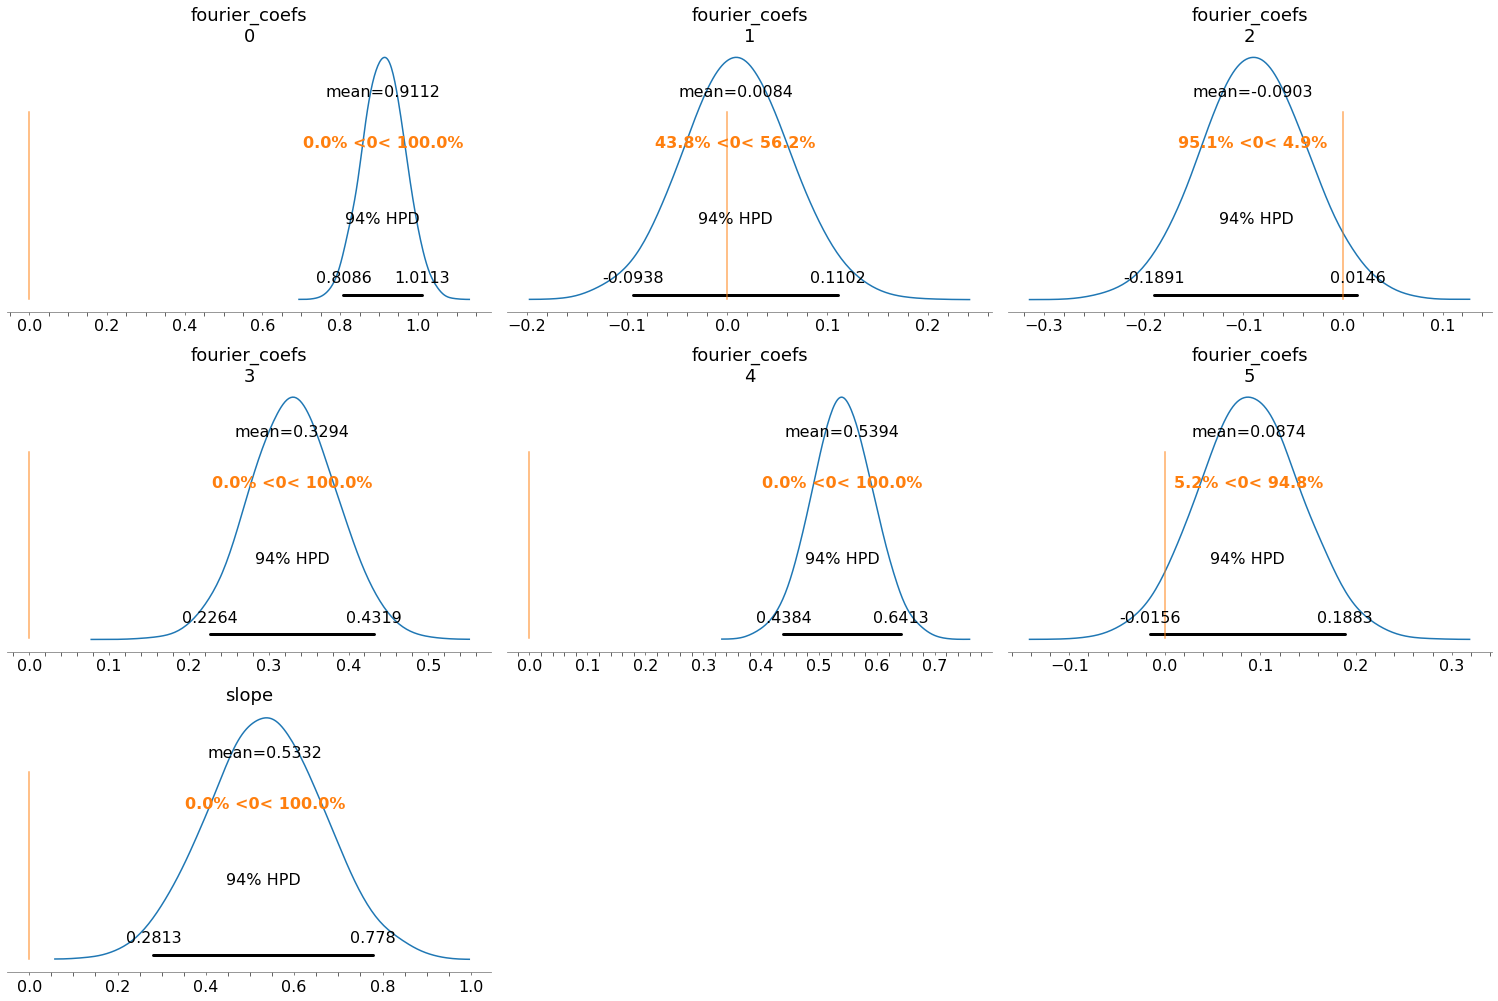

In [51]:
ar.plot_posterior(trace_m3f3, var_names=vars_, ref_val=0, round_to=4);

In [52]:
m3_f4.name ='m3_trend&fourierN4'
m3_f3.name = 'm3_trend&fourierN3'

In [53]:
ar.compare({m3_f4.name: trace_m3f4, m3_f3.name: trace_m3f3,
            m2_f3.name: trace_m2f3, m2_f4.name: trace_m2f4})

/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m3_trend&fourierN4,459.827,10.636,0,0.500978,23.701,0,True,deviance
m3_trend&fourierN3,460.137,8.71707,0.310322,0.451895,23.9068,4.08913,True,deviance
fourier_N4,473.036,8.8836,13.209,0.0250243,23.9462,7.12788,True,deviance
fourier_N3,473.532,7.08922,13.7047,0.0221025,23.7317,8.01946,True,deviance


Note that there's again a warning issued, likely due to some overly-influential datapoints, which might have been otherwise arbitrarily dismissed as outliers repeating the above with PSIS-LOOCV as before:

In [54]:
ar.compare({m3_f4.name: trace_m3f4, m3_f3.name: trace_m3f3,
            m2_f3.name: trace_m2f3, m2_f4.name: trace_m2f4}, ic='loo')

,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m3_trend&fourierN4,459.867,10.656,0,0.512035,23.5973,0,False,deviance
m3_trend&fourierN3,460.168,8.73218,0.300526,0.437664,23.8801,4.09007,False,deviance
fourier_N4,473.06,8.8958,13.1934,0.0295436,23.9278,7.12933,False,deviance
fourier_N3,473.55,7.09825,13.6827,0.0207573,23.5957,8.0211,False,deviance


The above shows that using PSIS-LOOCV for model performance assessment confirms, as with the previous attempt with WAIC that adding the linear trend to the fourier season approximation results in improved performance (*cf.* weight column.), though while the model incorporating a 4-component fourie seasonal sub-model peforms better, the weight proportion is not indicative of a clear advantage. However the standard error of the difference (dse column) is pretty large compared to the difference column (d_loo or d_waic, depending on the 'ic' used), jeopardizing the notion that performance increases are significant (see computation in the next cell).  I'll retain therefore all four models for further evaluation. 
Next is the addition of a  lag-1 autoregressive (AR1) sub-model for the residual signal and test whether we can squeeze out some more performance:

In [55]:
#2.6 refers to a z-score corresponding to 99%
13.7 + 8 *2.6*np.array([-1, 1]) > 0

array([False,  True])

<a id=TrendSeasonAr1 />

### Trend + Season + AR1 Residual

In [69]:
m4_f4 = pm.Model()
mdl_trend_season_ar1(m4_f4, n_fourier=4, t=t_s)

In [70]:
render_m4_f4 = pm.model_to_graphviz(m4_f4)
render_m4_f4.format = 'png'
render_m4_f4.render('m_linear_&_fourier_season_ar1', directory='../../figjar/')

'../../figjar/m_linear_&_fourier_season_ar1.png'

<img src='../../figjar/m_linear_&_fourier_season_ar1.png?:0' />

In [71]:
with m4_f4:
    trace_m4f4 = pm.sample(5000, tune=60000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, ar1, tau, k, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 260000/260000 [22:22<00:00, 193.72draws/s]
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [58]:
m4_f3 = pm.Model()
mdl_trend_season_ar1(m4_f3, n_fourier=3, t=t_s)
with m4_f3:
    trace_m4f3 = pm.sample(5000, tune=60000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, ar1, tau, k, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 220000/220000 [13:17<00:00, 275.75draws/s] 
There were 610 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8370924931974953, but should be close to 0.9. Try to increase the number of tuning steps.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8326860800519608, but should be close to 0.9. Try to increase the number of tuning steps.
There were 871 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7314808238949856, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3730 divergences after 

Note that as the model increases in complexity, the number of tuning steps is increased to minimize warningsd uring the fitting process. Note that we got some warnings nevertheless. This is not overly concerning, yet. These warnings will be useful for the knowledgeable practitioner to keep in mind however,  when digging into a given model for deeper introspection further down the line.

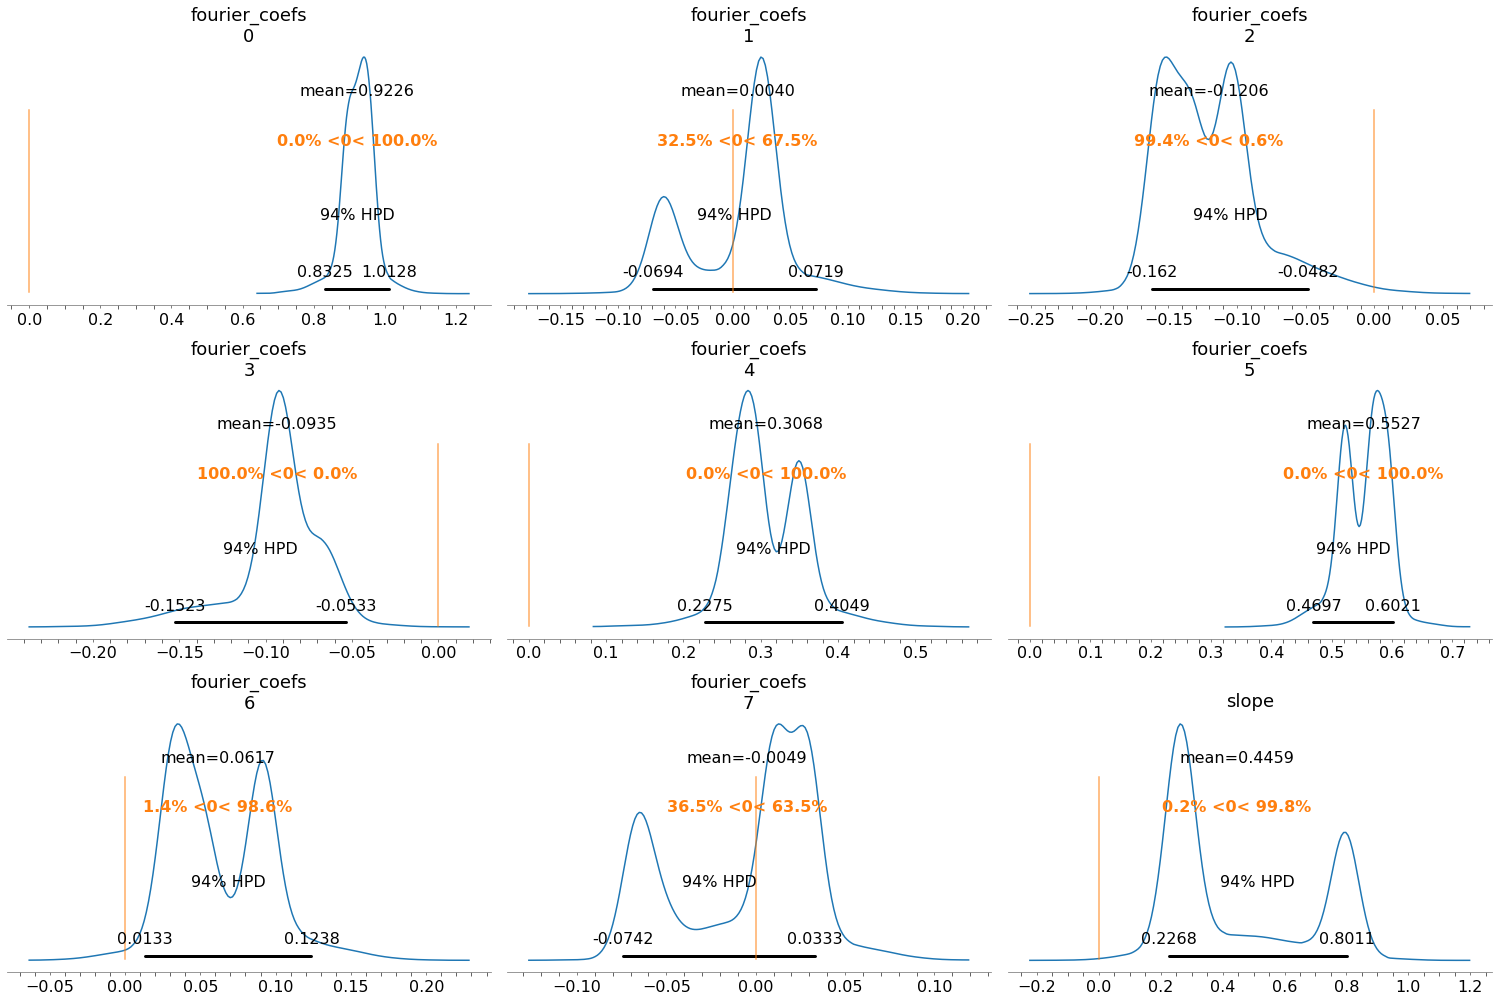

In [59]:
ar.plot_posterior(trace_m4f4, var_names=vars_, ref_val=0, round_to=4);

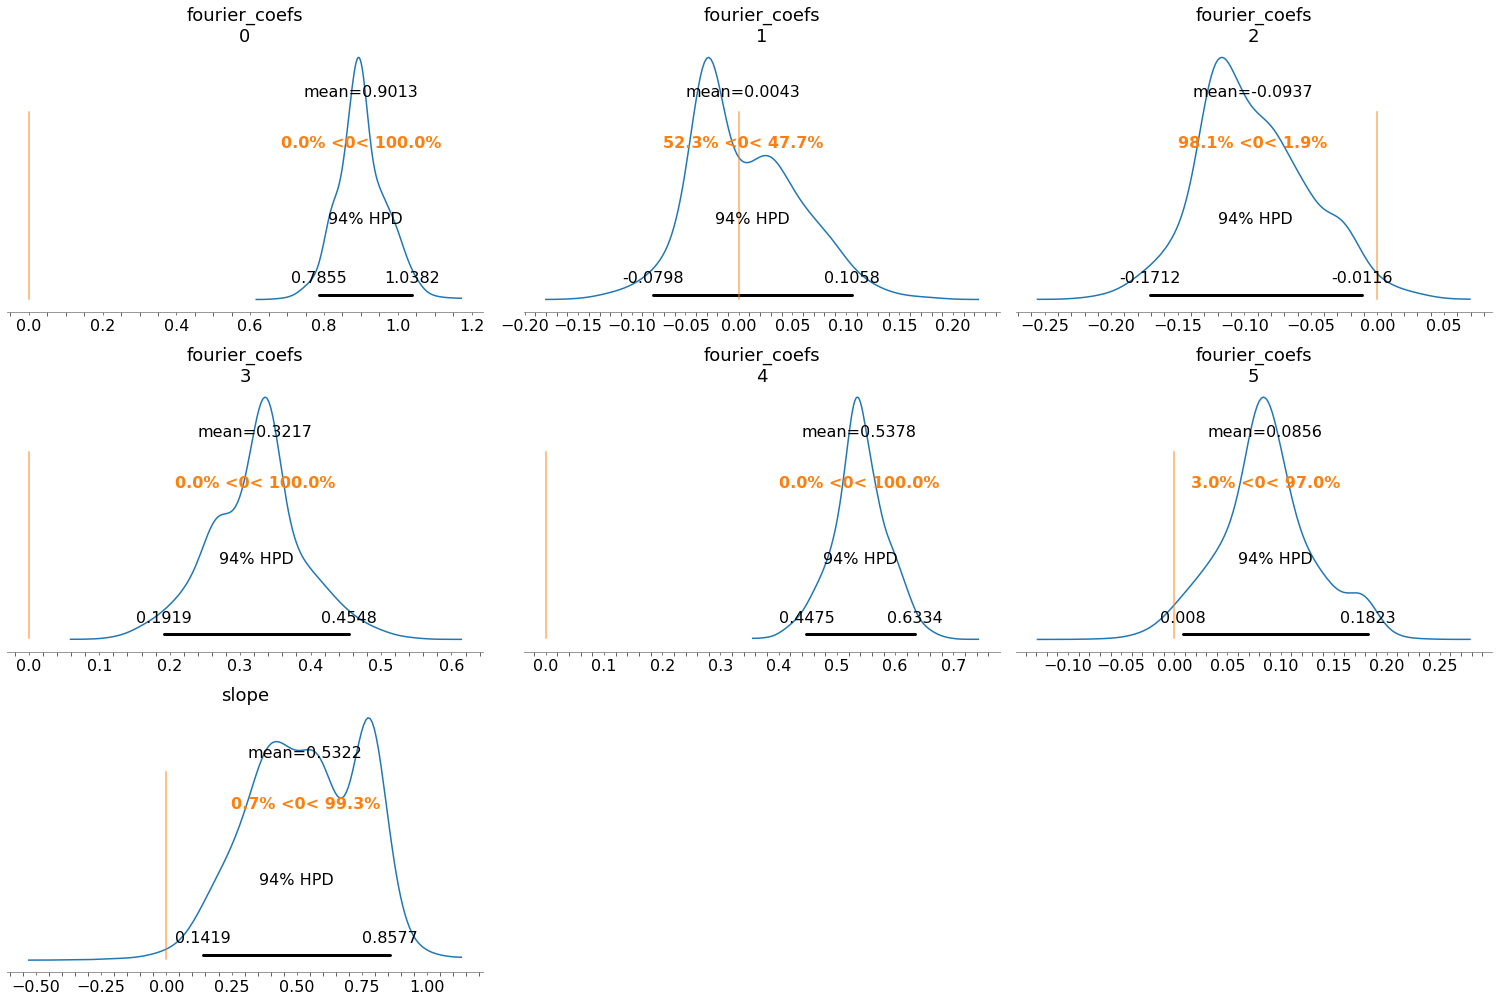

In [60]:
ar.plot_posterior(trace_m4f3, var_names=vars_, ref_val=0, round_to=4);

In [61]:
m4_f4.name='trend&fourier4&ar1'
m4_f3.name='trend&fourier3&ar1'

In [62]:
ar.compare({m3_f3.name: trace_m3f3, m3_f4.name: trace_m3f4,
            m4_f4.name: trace_m4f4, m4_f3.name: trace_m4f3,
            m2_f3.name: trace_m2f3, m2_f4.name: trace_m2f4})

/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
trend&fourier4&ar1,-643.541,315.274,0,1,23.0682,0,True,deviance
trend&fourier3&ar1,-157.616,228.363,485.925,2.17605e-98,23.2976,8.50597,True,deviance
m3_trend&fourierN4,459.827,10.636,1103.37,2.01248e-229,5.48878,22.4544,True,deviance
m3_trend&fourierN3,460.137,8.71707,1103.68,5.63573e-228,8.9098,22.5346,True,deviance
fourier_N4,473.036,8.8836,1116.58,2.18299e-230,23.4098,22.6433,True,deviance
fourier_N3,473.532,7.08922,1117.07,9.02933e-229,23.2198,22.6767,True,deviance


In [63]:
ar.compare({m3_f3.name: trace_m3f3, m3_f4.name: trace_m3f4,
            m4_f4.name: trace_m4f4, m4_f3.name: trace_m4f3,
            m2_f3.name: trace_m2f3, m2_f4.name: trace_m2f4}, ic='loo')

/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/arviz/stats/stats.py:442: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/arviz/stats/stats.py:442: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and hig

,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
trend&fourier4&ar1,-559.074,357.508,0,1,23.5507,0,True,deviance
trend&fourier3&ar1,-3.0878,305.627,555.986,1.49205e-114,23.7966,11.9888,True,deviance
m3_trend&fourierN4,459.867,10.656,1018.94,2.29666e-212,12.0349,20.5622,False,deviance
m3_trend&fourierN3,460.168,8.73218,1019.24,2.39806e-212,12.9036,20.6541,False,deviance
fourier_N4,473.06,8.8958,1032.13,2.66673e-215,24.1,20.8865,False,deviance
fourier_N3,473.55,7.09825,1032.62,1.95469e-215,23.8577,20.9097,False,deviance


The two IC methods agree on one thing, and that it's significantly better to add an AR1 residual sub-model to a model with an order-4 fourier series. The fitting warnings, and those from the above evaluation tables are a reminder that caution is advised and that actual out-of-sample testing is necessary.

In [81]:
ts_m4_f4 = trace_m4f4.get_values('μ')
ts_m4_f4_mu = ts_m4_f4.mean(axis=0)
ts_m4_f4_hpd = pm.hpd(ts_m4_f4)
ts_m4_f4_trend = trace_m4f4.get_values('trend')
ts_m4_f4_trend_mu = ts_m4_f4_trend.mean(axis=0)
ts_m4_f4_trend_hpd = pm.hpd(ts_m4_f4_trend)
ts_m4_f4_season = trace_m4f4.get_values('season')
ts_m4_f4_season_mu = ts_m4_f4_season.mean(axis=0)
ts_m4_f4_season_hpd = pm.hpd(ts_m4_f4_season)
ts_m4_f4_ar1 = trace_m4f4.get_values('ar1')
ts_m4_f4_ar1_mu = ts_m4_f4_ar1.mean(axis=0)
ts_m4_f4_ar1_hpd = pm.hpd(ts_m4_f4_ar1)

In [77]:
def plot_component(axi, x, y, hpd_=None, obs=None, line_label=None, y_axis_label=None,
                  ax_title=None):
    
    if isinstance(obs, np.ndarray):
        axi.plot(x, obs, color='k', label='observations')
    axi.plot(x, y, color='darkblue', label=line_label)
    if isinstance(hpd_, np.ndarray):
        axi.fill_between(x, hpd_[:, 0], hpd_[:, 1], color='steelblue',
                         alpha=0.5, label='95% CI')
    if y_axis_label:
        axi.set_ylabel(y_axis_label)
    axi.legend()
    if ax_title:
        axi.set_title(ax_title)
    axi.xaxis_date()
    axi.xaxis.set_major_locator(years)
    axi.xaxis.set_minor_locator(months)
    axi.tick_params(axis='x', labelrotation=30)
    axi.grid()

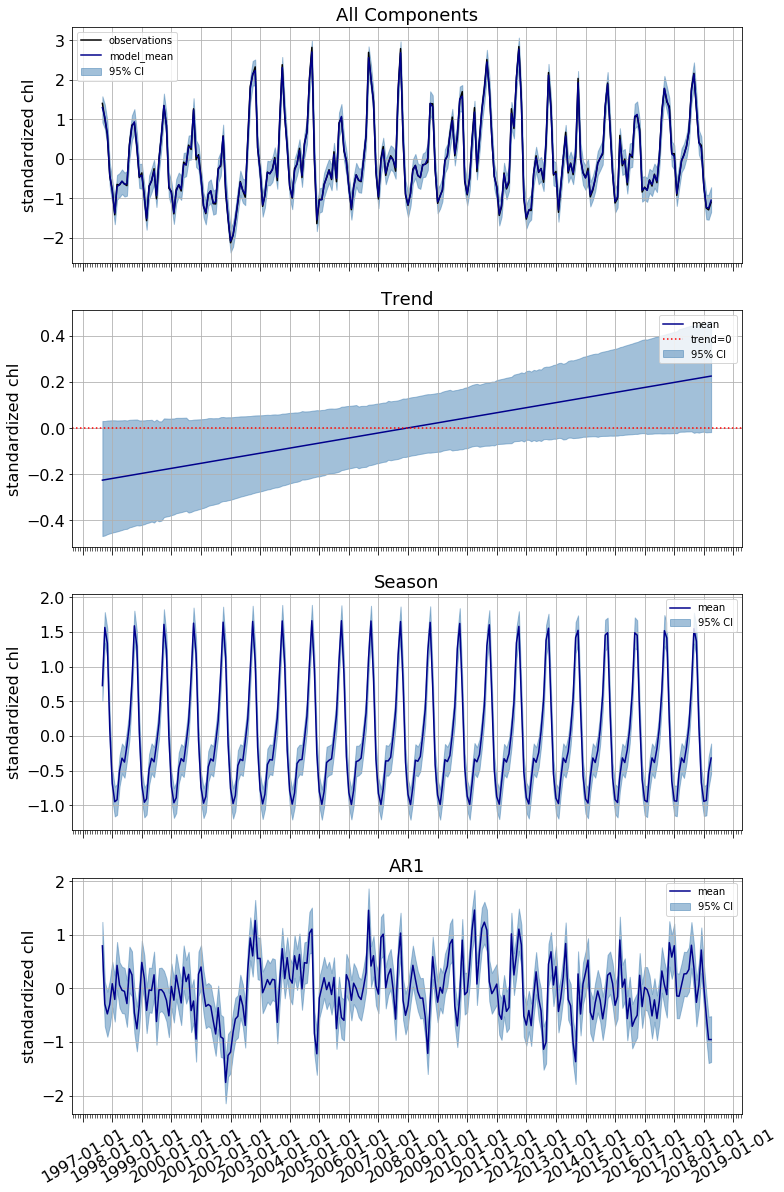

In [93]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))

ylbl = 'standardized chl'
plot_component(ax[0], d_aostz.index, ts_m4_f4_mu, hpd_=ts_m4_f4_hpd,
               obs=y_s, line_label='model_mean', y_axis_label=ylbl,
               ax_title='All Components')
plot_component(ax[1], d_aostz.index, ts_m4_f4_trend_mu, hpd_=ts_m4_f4_trend_hpd,
               line_label='mean', y_axis_label=ylbl, ax_title='Trend')
plot_component(ax[2], d_aostz.index, ts_m4_f4_season_mu, hpd_=ts_m4_f4_season_hpd,
               line_label='mean', y_axis_label=ylbl,
              ax_title='Season')
plot_component(ax[3], d_aostz.index, ts_m4_f4_ar1_mu, hpd_=ts_m4_f4_ar1_hpd,
              line_label='mean', y_axis_label=ylbl, ax_title='AR1')
ax[1].axhline(label='trend=0', color='r', ls=':');
ax[1].legend();

Plot above: Results of the model composed of global linear trend, order-4 fourier seaonality and AR1 residual sub-models, expected to perform best according to the PSIS-LOOCV criterion applied above. Top frame shows the data (black line) the model mean (blue line) and the model's 95% Credibility Interval (CI) indicating the region within which there's an estimated 95% chance of encountering an observation. Subsequent panels show the decomposition of the model into its components.
Note that the *Trend* plot does not entirely rule out the absence of a positive slope (red dotted line inside the 95% CI), but the chance of that being the case is quite minimal, as indicated by posterior distribution of the slope below. 

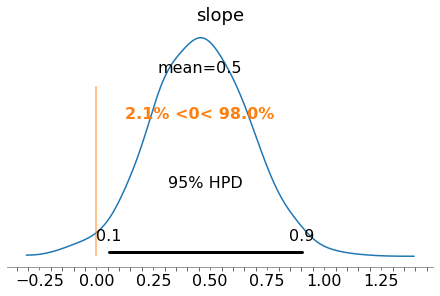

In [104]:
ar.plot_posterior(trace_m4f4, var_names=['slope',],
                  credible_interval=0.95, ref_val=0);

#### Inverse transform results of models where standardized data was used

In [83]:
mod4_mu_us = std_scaler.inverse_transform(ts_m4_f4_mu)
mod4_hpd_us = std_scaler.inverse_transform(ts_m4_f4_hpd)
mod4_trend_hpd_us = std_scaler.inverse_transform(ts_m4_f4_trend_hpd)
mod4_trend_mu_us = std_scaler.inverse_transform(ts_m4_f4_trend_mu)
mod4_season_hpd_us = std_scaler.inverse_transform(ts_m4_f4_season_hpd)
mod4_season_mu_us = std_scaler.inverse_transform(ts_m4_f4_season_mu)
mod4_ar1_hpd_us = std_scaler.inverse_transform(ts_m4_f4_ar1_hpd)
mod4_ar1_mu_us = std_scaler.inverse_transform(ts_m4_f4_ar1_mu)

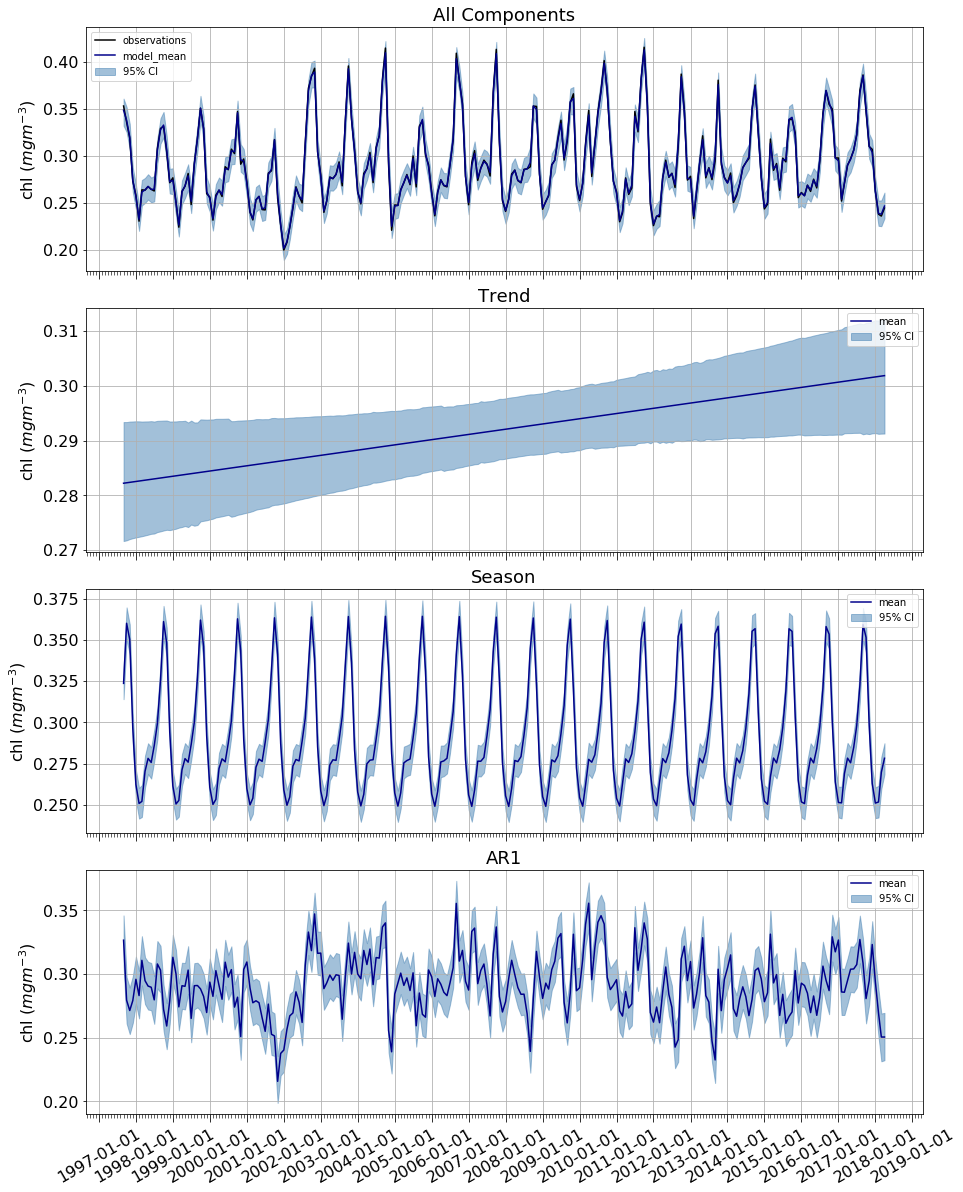

In [86]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(15, 20))
plot_component(ax[0], d_aostz.index, mod4_mu_us, hpd_=mod4_hpd_us,
               obs=y, line_label='model_mean',
               y_axis_label='chl $(mg m^{-3})$', ax_title='All Components')
plot_component(ax[1], d_aostz.index, mod4_trend_mu_us, hpd_=mod4_trend_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Trend')
plot_component(ax[2], d_aostz.index, mod4_season_mu_us, hpd_=mod4_season_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Season')
plot_component(ax[3], d_aostz.index, mod4_ar1_mu_us, hpd_=mod4_ar1_hpd_us,
              line_label='mean', y_axis_label='chl $(mg m^{-3})$', ax_title='AR1')
f.subplots_adjust(hspace=0.15)

In this notebook I used several generalized additive models composed of one or more of the following components, a global trend sub-model, a seasonal sub-model built from a fourier series, and a residual signal modeled as an AR process for lag 1. The better model, as established by the use of Importance Sampling Leave-One-Out Cross Validation feature all 3 component, with the seasonal cycle a fourier series of order 4. There were some warnings during both fitting and model evaluation regarding this and other models, possibly due to some of data having undue influence on the inference. While not necessarily problematic, it does suggest that the parameter topology that the Hamiltonian Monte Carlo Sampler used here has to deal with is challenging, and that an alternative parameterization of this model, or development of more sophisticated models may improve predictions. 

In one of two upcoming notebooks, I will attempt to develop models similar to the ones presented here replacing the global linear trend component with  a local linear trend component, where the signal is punctuated by switchpoints. 

In the other of the upcoming notebooks I will use a non-parametric kernel approach to take advantage of cross-correlations within the time series to unearth potential trends on various scales.